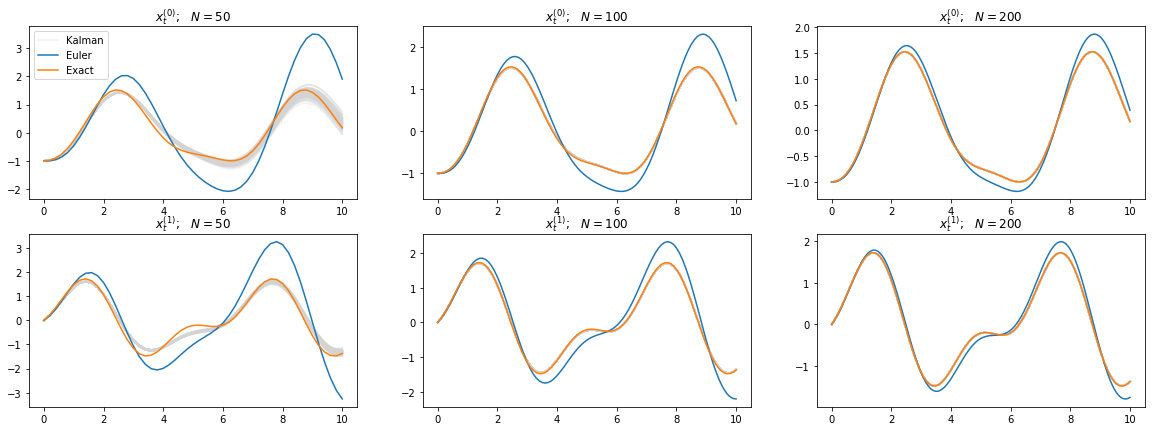

In [3]:
import numpy as np
from math import sin
import matplotlib.pyplot as plt
%matplotlib inline

from probDE.ibm import ibm_init
from probDE.cython.KalmanODE import KalmanODE
from probDE.utils import indep_init, zero_pad
from readme_graph import readme_graph

# ODE function
def ode_fun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.empty(1)
    x_out[0] = sin(2*t) - x[0]
    return

def chkrebtii_example():
    r"Produces the graph in Figure 1 of the paper."
    # LHS vector of ODE
    # 2.  Define the IVP

    # ODE function
    def ode_fun(x, t, theta=None, x_out=None):
        if x_out is None:
            x_out = np.empty(1)
        x_out[0] = sin(2*t) - x[0]
        return

    W = np.array([[0.0, 0.0, 1.0]])  # LHS vector of ODE
    x0 = np.array([-1., 0., 1.])  # initial value for the IVP

    # Time interval on which a solution is sought.
    tmin = 0
    tmax = 10

    # 3.  Define the prior process
    #
    # (Perhaps best to describe this in text, not code comments)
    #
    # We're going to use a solution prior that has one more derivative than as specified in the IVP.  
    # To do this, we'll pad the original IVP with zeros, for which we have the convenience function 
    # zero_pad().

    n_deriv = [2]  # number of derivatives in IVP
    n_deriv_prior = [4]  # number of derivatives in IBM prior

    # zero padding
    W_pad = zero_pad(W, n_deriv, n_deriv_prior)
    x0_pad = zero_pad(x0, n_deriv, n_deriv_prior)

    # IBM process scale factor
    sigma = [.5]

    # 4.  Instantiate the ODE solver object.

    n_points = 80  # number of steps in which to discretize the time interval.
    dt = (tmax-tmin)/n_points  # step size

    # generate the Kalman parameters corresponding to the prior
    prior = ibm_init(dt, n_deriv_prior, sigma)

    # instantiate the ODE solver
    ode = KalmanODE(W=W_pad,
                    tmin=tmin,
                    tmax=tmax,
                    n_eval=n_points,
                    fun=ode_fun,
                    **prior)


    # 5.  Evaluate the ODE solution

    # deterministic output: posterior mean
    mut, Sigmat = ode.solve_mv(x0=x0_pad)

    # probabilistic output: draw from posterior
    xt = ode.solve_sim(x0=x0_pad)
    
    # Produces the graph in Figure 1
    draws = 100
    readme_graph(ode_fun, n_deriv, n_deriv_prior, tmin, tmax, W, x0, draws)
    return

if __name__ == '__main__':
    chkrebtii_example()
    

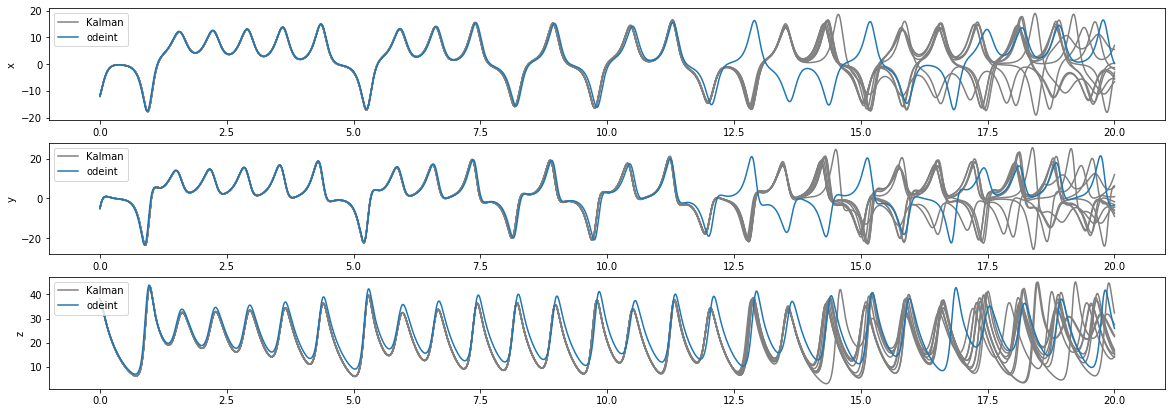

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from probDE.car import car_init
from probDE.cython.KalmanODE import KalmanODE
from probDE.utils import indep_init, zero_pad
from lorenz_graph import lorenz_graph

# RHS of ODE
def lorenz(X, t, theta,  out=None):
    if out is None:
        out = np.empty(3)
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y -x*z
    out[2] = -beta*z + x*y
    return out

def lorenz_example():
    r"Produces the graph in Figure 2 of the paper."

    # theta for this example
    theta = np.array([28, 10, 8/3])

    # Initial value, x0, for the IVP
    x0 = [-12, -5, 38]
    v0 = [70, 125, -124/3]
    X0 = np.column_stack([x0, v0])

    # prior process definition
    n_deriv = [1, 1, 1] # number of derivatives in IVP
    n_deriv_prior = [3, 3, 3] # number of derivatives in IBM prior

    # LHS Matrix of ODE
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1

    # pad the inputs
    W_pad = zero_pad(W_mat, n_deriv, n_deriv_prior)

    # Time interval on which a solution is sought.
    tmin = 0
    tmax = 20

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    tau = np.array([1.3, 1.3, 1.3])
    sigma = np.array([.5, .5, .5])

    n_points = 5000 # number of steps in which to discretize the time interval.
    dt = (tmax-tmin)/n_points # step size
    
    # generate the Kalman parameters corresponding to the prior
    ode_init, x0_pad = car_init(dt, n_deriv_prior, tau, sigma, X0)
    kinit = indep_init(ode_init, n_deriv_prior)

    # Initialize the Kalman class
    kalmanode = KalmanODE(W_pad, tmin, tmax, n_points, lorenz, **kinit)
    # Run the solver to get an approximation
    kalman_sim = kalmanode.solve_sim(x0_pad, theta=theta)

    # Produce the graph in Figure 2
    draws = 10
    lorenz_graph(lorenz, n_deriv, n_deriv_prior, tmin, tmax, n_points, W_mat, tau, sigma, X0, theta, draws)
    return

if __name__ == '__main__':
    lorenz_example()


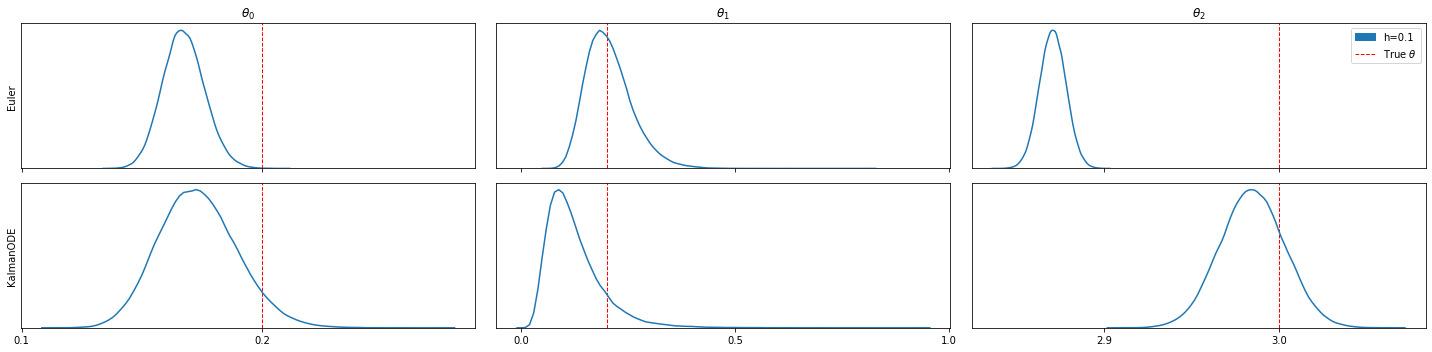

In [5]:
import numpy as np
from inference import inference
from probDE.ibm import ibm_init
from probDE.cython.KalmanODE import KalmanODE
from probDE.utils import indep_init, zero_pad

def fitz(X_t, t, theta, out=None):
    "FN ODE function with optional overwriting of output."
    if out is None:
        out = np.empty(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    out[0] = c*(V - V*V*V/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return out

def fitz_example():
    "Perform parameter inference using the FitzHugh-Nagumo function."
    # These parameters define the order of the ODE and the CAR(p) process
    n_deriv = [1, 1] # Total state
    n_obs = 2 # Total measures
    n_deriv_prior = [3, 3]
    p = sum(n_deriv_prior)
    state_ind = [0, 3] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0 
    tmax = 40

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 2
    sigma = [.1]*n_var

    # Initial value, x0, for the IVP
    x0 = np.array([-1., 1.])
    v0 = np.array([1, 1/3])
    X0 = np.ravel([x0, v0], 'F')

    # pad the inputs
    w_mat = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]])
    W = zero_pad(w_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    theta_true = np.array([0.2, 0.2, 3]) # True theta
    n_theta = len(theta_true)
    phi_sd = np.ones(n_theta) 

    # Observation noise
    gamma = 0.2

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, fitz)
    Y_t = inf.simulate(fitz, x0, theta_true, gamma)

    # Parameter inference using Euler's approximation
    hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    theta_euler = np.zeros((len(hlst), n_samples, n_theta))
    for i in range(len(hlst)):
        phi_hat, phi_var = inf.phi_fit(Y_t, x0, hlst[i], theta_true, phi_sd, gamma, False)
        theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)

    # Parameter inference using Kalman solver
    theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
    for i in range(len(hlst)):
        ode_init = ibm_init(hlst[i], n_deriv_prior, sigma)
        x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
        kinit = indep_init(ode_init, n_deriv_prior)
        n_eval = int((tmax-tmin)/hlst[i])
        kode = KalmanODE(W, tmin, tmax, n_eval, fitz, **kinit)
        inf.kode = kode
        inf.W = W
        phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)
        theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
    
    # Produces the graph in Figure 3
    inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst)
    return

if __name__ == '__main__':
    fitz_example()
    

In [ ]:
import numpy as np
from inference import inference
from probDE.ibm import ibm_init
from probDE.cython.KalmanODE import KalmanODE
from probDE.utils import indep_init, zero_pad

def mseir(X_t, t, theta, out=None):
    "MSEIR ODE function"
    if out is None:
        out = np.empty(5)
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    out[0] = Lambda - delta*M - mu*M
    out[1] = delta*M - beta*S*I/N - mu*S
    out[2] = beta*S*I/N - (epsilon + mu)*E
    out[3] = epsilon*E - (gamma + mu)*I
    out[4] = gamma*I - mu*R
    return out

def mseir_example():
    "Perform parameter inference using the MSEIR function."
    # These parameters define the order of the ODE and the CAR(p) process
    n_deriv = [1]*5 # Total state
    n_deriv_prior= [3]*5
    state_ind = [0, 3, 6, 9, 12] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0
    tmax = 40

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 5
    sigma = [.1]*n_var

    # Initial value, x0, for the IVP
    theta_true = (1.1, 0.7, 0.4, 0.005, 0.02, 0.03) # True theta
    x0 = np.array([1000, 100, 50, 3, 3])
    v0 = mseir(x0, 0, theta_true)
    X0 = np.ravel([x0, v0], 'F')

    # W matrix: dimension is n_eq x sum(n_deriv)
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
    W = zero_pad(W_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    n_theta = len(theta_true)
    phi_sd = np.ones(n_theta)

    # Observation noise
    gamma = 0.2

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, mseir)
    Y_t = inf.simulate(mseir, x0, theta_true, gamma)

    # Parameter inference using Euler's approximation
    hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    theta_euler = np.zeros((len(hlst), n_samples, n_theta))
    for i in range(len(hlst)):
        phi_hat, phi_var = inf.phi_fit(Y_t, x0, hlst[i], theta_true, phi_sd, gamma, False)
        theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
    
    # Parameter inference using Kalman solver
    theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
    for i in range(len(hlst)):
        ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
        x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
        kinit = indep_init(ode_init, n_deriv_prior)
        n_eval = int((tmax-tmin)/hlst[i])
        kode = KalmanODE(W, tmin, tmax, n_eval, mseir, **kinit)
        inf.kode = kode
        inf.W = W
        phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)
        theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
    
    # Produces the graph in Figure 4
    inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst)
    return

if __name__ == '__main__':
    mseir_example()